# Анализ удовлетворенности клиентов. Исследование комфорта при работе климатического оборудования.

## Описание проекта

### Поставленная задача

Проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах?

### Описание данных

**Год** - Год проведения исследования<br>
**Время года** - Весна, лето, осень, зима<br>
**Климат** - Название типа климата<br> 
**Город** - Город, где было проведено исследование<br> 
**Страна** - Страна, где было проведено исследование<br>
**Способ охлаждения**:<br>
- **Кондиционирование** = может быть разных типов, окна закрыты.
- **Вентиляция** = механические системы вентиляции и естественное охлаждение.
- **Смешанный** = механическое охлаждение, окна могут быть как открыты, так и закрыты.
- **NA** = не применимо, например исследование холодной зимой, когда включено отопление.
  
**Режим при смешанном типе охлаждения**:<br>
- **NA** = здания, не относящиеся к смешанному типу.
- **Кондиционер** = кондиционер включен, окна закрыты.
- **Вентиляция** = кондиционер выключен, окна открыты/механическая
	вентиляция.

**Способ обогрева**:
- **Механическое отопление** = в здании имеется механическая система отопления (переносные обогреватели не считаются механическим отоплением на уровне здания).
- **NA** = отсутствие механического отопления, неизвестно или исследование только в жаркую летнюю погоду.
  
**Возраст** - Возраст респондента<br>
**Пол** - Пол респондента<br> 
**Ощущение температуры** - Оценка температуры по ощущениям: от -3 (холодно) до +3 (горячо)<br>
**Ощущение температуры (bool)** - 0 = неприемлемо, 1 = приемлемо<br> 
**Предпочтительное изменение температуры** - Без изменений, теплее, холоднее<br> 
**Ощущение движения воздуха (bool)** - 0 = неприемлемо, 1 = приемлемо <br>
**Предпочтительное изменение движения воздуха** - Меньше, без изменений, больше<br> 
**Оценка комфорта** - От 1 (очень неудобно) до 6 (очень комфортно) <br>
**Утепление** - Фактор связанный с одеждой респондента<br> 
**Температура воздуха в помещении** - Измеренная температура в помещении<br> 
**Температура воздуха на улице** - Измеренная температура на улице <br>
**RH** - Относительная влажность <br>
**Скорость воздуха** - Скорость воздуха, м/с<br> 
**Рост** - Рост респондента<br>
**Вес** - Вес респондента <br>
**Занавески** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Вентилятор** - Режим вентилятора: 0 = выключен, 1 = включен; если неизвестно - нет данных<br> 
**Окно** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Двери** - 0 = открыты, 1 = закрыты; если неизвестно - нет данных<br>
**Отопление** - Режим обогрева: 0 -выключен, 1 - включен; если неизвестно - нет данных<br> 
**Среднемесячная температура на улице** - Среднемесячная температура наружного воздуха на момент исследования, C.<br>
**Количество рекламаций** - Количество жалоб на установленное оборудование, полученных от клиента, за прошедший период<br>

## Imports

### Скачивание библиотек

In [ ]:
pip install pandas

In [ ]:
pip install numpy

In [ ]:
pip install matplotlib

In [ ]:
pip install scipy

In [ ]:
pip install seaborn

In [ ]:
pip install -U scikit-learn

### Подключение библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu, ttest_ind, shapiro

## Path

In [3]:
MAIN_TABLE = 'data.csv'

## User functions

In [4]:
class SeparatorError(Exception):
    pass

# чтение файла и работа над форматом PEP8 для названий столбцов
def read_file(PATH):
    encodes = ['utf-8', 'cp1251']
    separators = [';', ',']
    dcml = '.'
    data = pd.DataFrame()
    for encode in encodes:
        for separator in separators:
            try:
                data = pd.read_csv(PATH, sep=separator, encoding=encode, decimal=dcml)
                data.columns = data.columns.str.lower().str.replace(' ', '_')
                if len(data.columns) == 1:
                    raise SeparatorError
                return data
            except UnicodeError:
                data = pd.DataFrame({'error': ['encoding']})
            except SeparatorError:
                data = pd.DataFrame({'error': ['separator']})
            except FileNotFoundError:
                data = pd.DataFrame({'error': ['file_path']})
    return data

In [5]:
# смена типа данных в столбцах(columns - словарь(key=название столбца, value - новый тип данных))
def change_types(data, columns):
    for key, val in columns.items():
        try:
            data[key] = data[key].astype(val)
        except ValueError:
            print('Ошибка при изменении типа данных в столбце с именем ', key)
        except KeyError:
            print('Возможно было неправильно указано название столбца', key)

In [6]:
# вывод уникальных значений по столбцам
def unique_values(data, columns):
    print('###########')
    print(*['\n###########\n'.join([column, '\n'.join(data[column].unique())]) for column in columns], sep='\n\n###########\n')

In [7]:
# расчет корреляции между категориальном и количественным столбцом.
def correlation_ratio(data, categories, values):
    group = data.groupby(categories)[values]
    counts = group.count()
    group_means = group.mean()
    mg = sum(counts * (group_means - data[values].mean()) ** 2)
    vg = sum((data[values] - data[categories].map(group_means)) ** 2)
    return np.sqrt(mg / (mg + vg))

In [8]:
# расчет корреляции между категориальном и категориальным столбцом.
def my_cramers(x, y):
    data = pd.crosstab(x, y)
    n = data.sum().sum()
    theory = np.outer(data.values.sum(axis=1),
                      data.values.sum(axis=0)) / n
    chi2 = ((data.values - theory) ** 2 / theory).sum()
    chi2 = chi2_contingency(data)[0]
    r, c = data.values.shape
    if min(r - 1, c - 1) == 0:
        cramer = 0
    else:
        cramer = np.sqrt(chi2 / (n * min(r - 1, c - 1)))
    return cramer

In [9]:
# columns - список названий столбцов, по которым будем строить ящик с усами.
def boxplot_chart(data, columns):
    for column in columns:
        sns.boxplot(data, y=column)
        plt.title(f'График ящик с усами для столбца {column}', loc='center')
        plt.show()       

## Preproccesing

Чтение данных из файла и приведение названия столбцов в соответствии с PEP8

In [119]:
df = read_file(MAIN_TABLE)
df['возраст'].sample(10)

246    35.0
98     45.0
371    25.0
16     38.0
406    55.0
408     NaN
469     NaN
212    45.0
231    35.0
186    45.0
Name: возраст, dtype: float64

Проверим название столбцов

In [120]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Уберем лишнее

In [121]:
df.columns = df.columns.str.replace('(', '').str.replace(')', '')
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_bool',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Выведем информацию про каждый столбец

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

In [123]:
columns = {'год': int, 'возраст': float, 'ощущение_температуры': float, 'ощущение_температуры_bool': bool, 
           'ощущение_движения_воздуха_bool': bool, 'оценка_комфорта': float, 'утепление': float,
           'температура_воздуха_в_помещении': float, 'температура_воздуха_на_улице': float,
           'rh': float, 'скорость_воздуха': float, 'рост': float, 'вес': float, 'занавески': bool,
           'вентилятор': bool, 'окно': bool, 'двери': bool, 'отопление': bool, 'среднемесячная_температура_на_улице': float}
change_types(df, columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int64  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

Пока не заполнили пропуски в возрасте, его преобразовывать в int нельзя. После заполнения нужно про это вспомнить и изменить.

Посмотрим описательную статистику для количественных типов данных

In [124]:
df.describe(exclude=object)

,год,возраст,ощущение_температуры,ощущение_температуры_bool,ощущение_движения_воздуха_bool,оценка_комфорта,утепление,температура_воздуха_в_помещении,температура_воздуха_на_улице,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
count,484.000000,413.000000,484.000000,484,484,215.000000,484.000000,484.000000,72.000000,484.000000,484.000000,143.000000,214.000000,484,484,484,484,484,484.000000,484.000000
unique,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,NaN,NaN
top,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True,True,NaN,NaN
freq,NaN,NaN,NaN,382,435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,449,415,274,356,467,NaN,NaN
mean,2011.033058,40.634383,0.203306,NaN,NaN,4.772093,0.634587,26.072107,24.104167,52.973760,0.760558,164.411678,65.471963,NaN,NaN,NaN,NaN,NaN,27.389669,0.105372
std,0.922988,11.001301,1.091976,NaN,NaN,1.261161,0.253103,7.681363,0.604546,13.036204,4.921106,21.273235,11.574079,NaN,NaN,NaN,NaN,NaN,19.469562,0.440276
min,2010.000000,22.000000,-3.000000,NaN,NaN,1.000000,0.360000,16.200000,22.800000,23.800000,0.000000,5.230000,42.000000,NaN,NaN,NaN,NaN,NaN,8.500000,0.000000
25%,2010.000000,35.000000,0.000000,NaN,NaN,4.000000,0.460000,23.800000,23.800000,42.775000,0.060000,160.000000,57.000000,NaN,NaN,NaN,NaN,NaN,22.000000,0.000000
50%,2011.000000,42.000000,0.000000,NaN,NaN,5.000000,0.590000,24.600000,24.100000,53.750000,0.100000,165.100000,65.000000,NaN,NaN,NaN,NaN,NaN,22.000000,0.000000
75%,2012.000000,45.000000,1.000000,NaN,NaN,6.000000,0.700000,25.900000,24.400000,62.325000,0.140000,172.700000,72.750000,NaN,NaN,NaN,NaN,NaN,30.800000,0.000000


Посмотрим ящики с усами для всех интересующих нас количественных столбцов для выявления возможных выбросов.

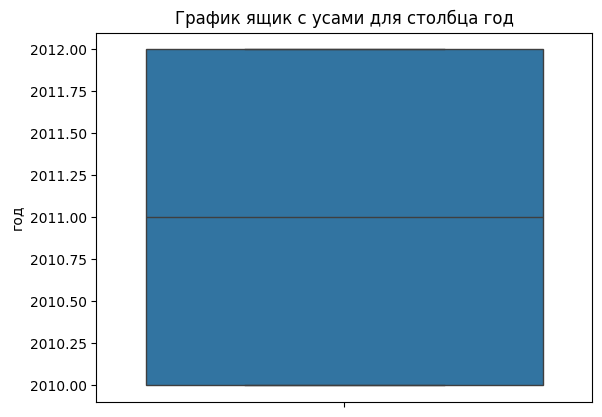

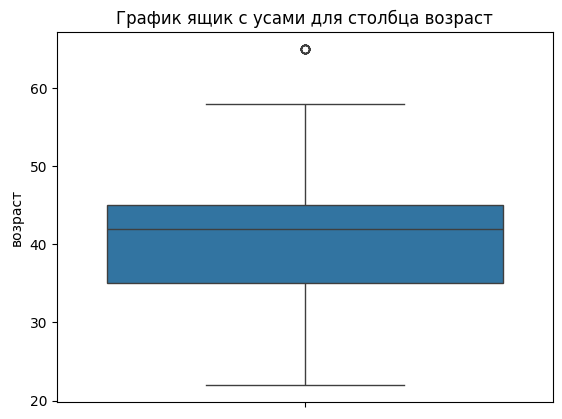

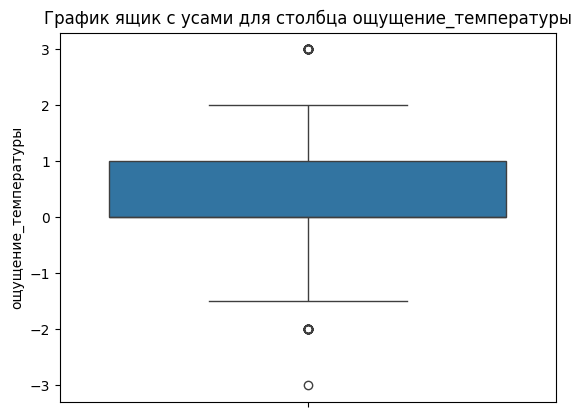

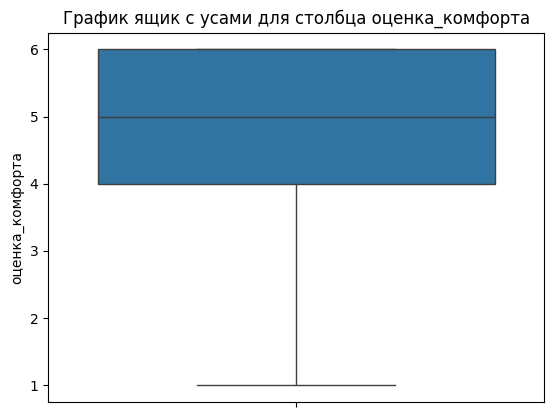

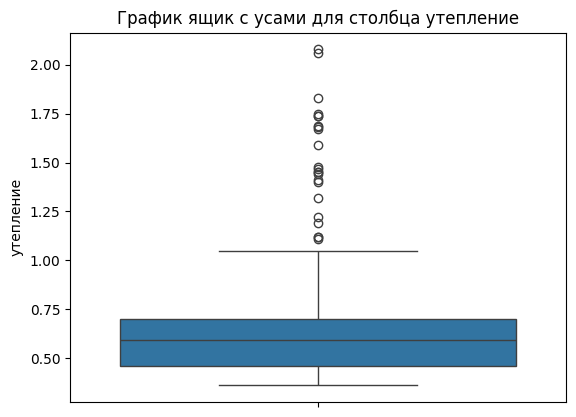

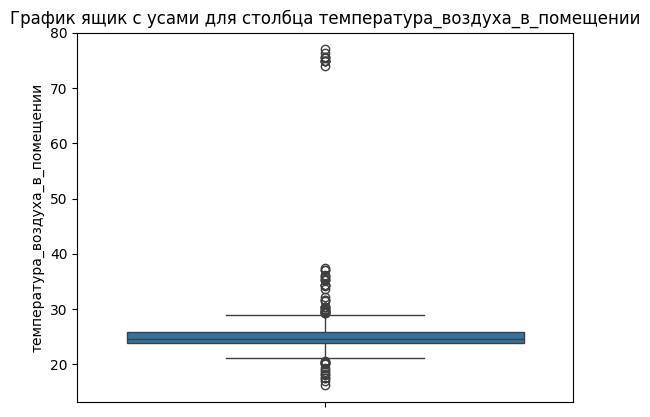

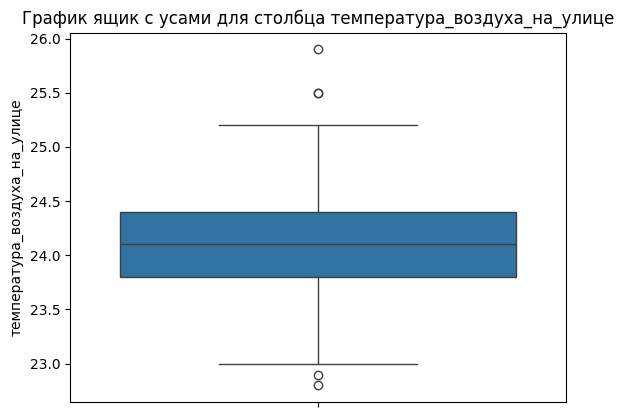

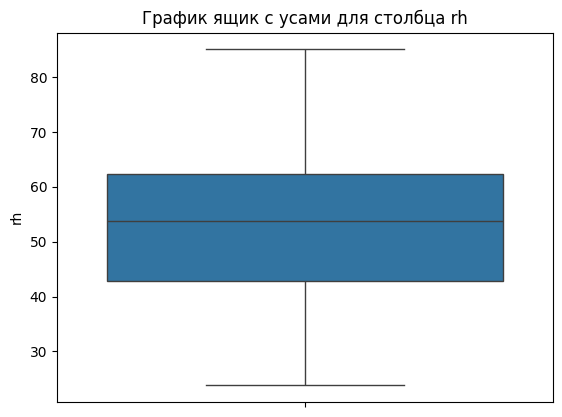

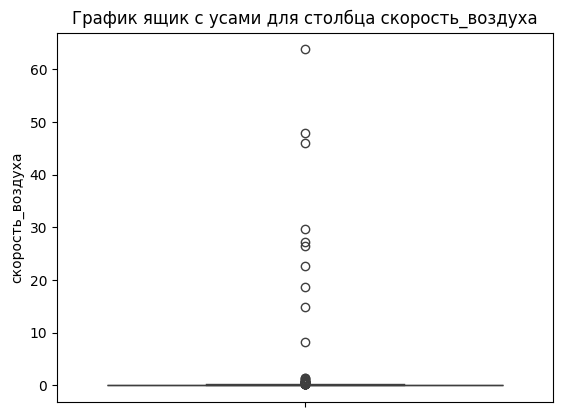

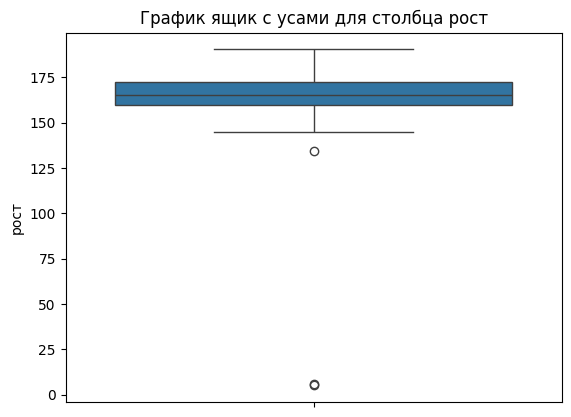

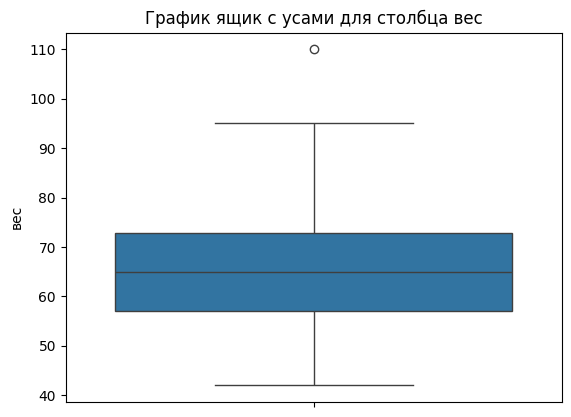

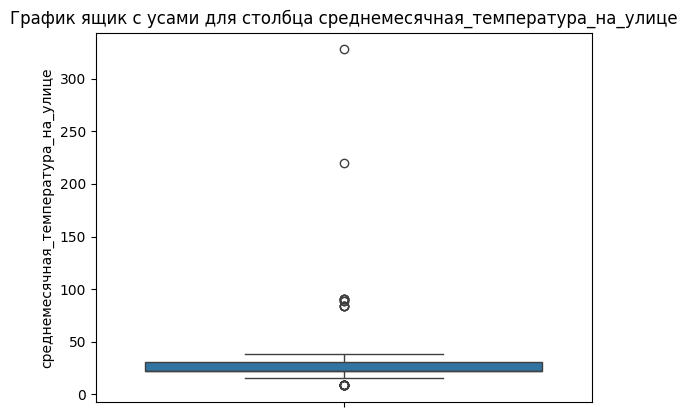

In [125]:
columns = ['год', 'возраст', 'ощущение_температуры', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении',
           'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'среднемесячная_температура_на_улице']
boxplot_chart(df, columns)

In [126]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_bool',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Сделаем выводы по этим графикам: <br>
- со столбцом год все нормально.
- со столбцом возраст все нормально.
- к столбцу ощущение_температуры есть вопросы. Взглянем на строки, где встретились выбросы.
- со столбцом оценка_комфорта выбросов не наблюдаем, по значениям будет обговорено позже.
- со стобцом утепление нужно разобраться, разобьем его на группы по временам года и посмотрим график.
- со столбцом температура_воздуха_в_помещении нужно разобраться почему присутствуют выбросы. Скорее всего связано со спецификой работы.
- со столбцом температура_воздуха_на_улице все нормально.
- со столбцом rh на первый взгляд все нормально.
- к столбцу скорость_воздуха есть вопросы. Очень странные выбросы.
- к столбцу рост есть вопросы. Посмотрим почему возникли выбросы и разрешим эту проблему.
- со столбцом вес все нормально.(Не можем утверждать, что присутствуют выбросы)
- со столбцом среднемесячная_температура_на_улице проблемы. Рассмотрим строки с этими значениями более подробно.

In [56]:
df.query('ощущение_температуры < -2 | ощущение_температуры > 2')[['климат', 'время_года', 'страна', 'ощущение_температуры', 
                                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                 'среднемесячная_температура_на_улице']].sort_values(by='ощущение_температуры')

,климат,время_года,страна,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
350,Тропическая влажная саванна,Весна,Индия,-3.0,NaN,26.6,30.400000
76,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.7,22.000000
203,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.1,22.000000
176,Cубтропический океанический,Лето,Австралия,3.0,NaN,22.9,22.000000
211,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.5,22.000000
222,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.4,22.000000
261,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.2,22.000000
208,Cубтропический океанический,Лето,Австралия,3.0,NaN,23.9,22.000000
264,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.8,22.000000
283,Жаркий полузасушливый,Весна,Индия,3.0,NaN,28.7,31.500000


In [57]:
df['ощущение_температуры'].describe()

count    484.000000
mean       0.203306
std        1.091976
min       -3.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ощущение_температуры, dtype: float64

Однозначных выводов, как заменить выбросы в столбце ощущение_температуры нет.

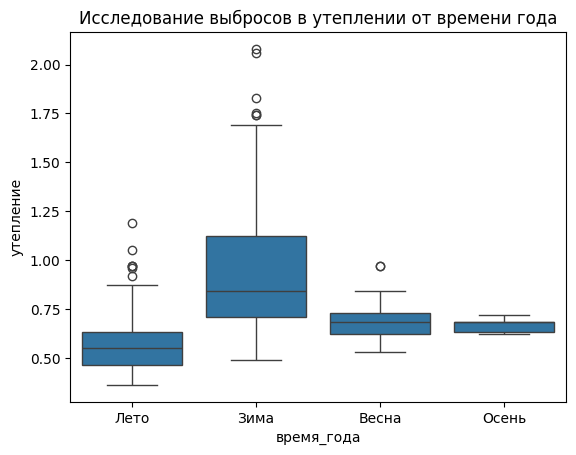

In [127]:
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

Выбросы в утеплении летом могут поломать логику нашего исследования, я хочу устранить их путем заменой на групповую медиану по времени года.

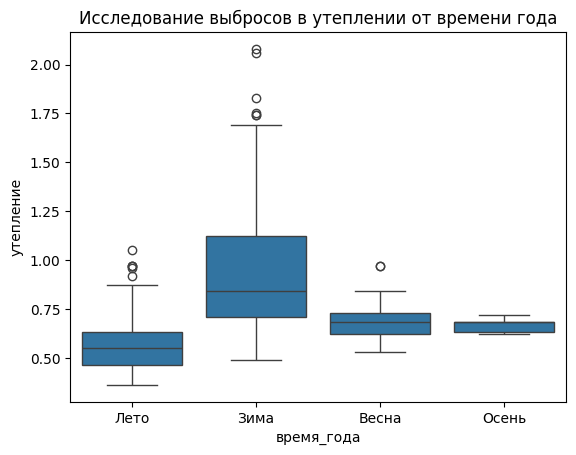

In [129]:
q1 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.25)
q3 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.75)
mask = df[(df['время_года'] == 'Лето') & (df['утепление'] > q3 + 3 * (q3 - q1))].index.to_list()
df.loc[mask, 'утепление'] = df.groupby('время_года')['утепление'].transform('median')
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

In [46]:
df.query('температура_воздуха_в_помещении > 40')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                  'среднемесячная_температура_на_улице']].sort_values(by='температура_воздуха_в_помещении')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
45,Cубтропический океанический,Лето,США,Техас,-1.0,23.3,74.0,31.7
1,Cубтропический океанический,Лето,США,Техас,-2.0,23.7,74.8,84.0
7,Cубтропический океанический,Лето,США,Техас,-2.0,23.6,74.8,32.8
33,Cубтропический океанический,Лето,США,Техас,-1.0,24.2,74.9,32.8
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,74.9,84.0
38,Cубтропический океанический,Лето,США,Техас,1.0,24.3,75.5,28.9
54,Cубтропический океанический,Лето,США,Техас,-2.0,24.1,75.7,28.9
41,Cубтропический океанический,Лето,США,Техас,0.0,24.1,75.7,31.7
9,Cубтропический океанический,Лето,США,Техас,1.0,24.4,76.4,31.7
23,Cубтропический океанический,Лето,США,Техас,1.6,24.7,77.0,32.8


У данных выбросов есть интересная схожесть - страна, где проходили исследования. США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

In [47]:
df['температура_воздуха_в_помещении'] = df['температура_воздуха_в_помещении'].apply(lambda x: x if x < 40 else ((5 / 9) * (x - 32)))
df['температура_воздуха_в_помещении'].describe()

count    484.000000
mean      25.012695
std        2.762848
min       16.200000
25%       23.800000
50%       24.600000
75%       25.700000
max       37.400000
Name: температура_воздуха_в_помещении, dtype: float64

In [66]:
df.query('скорость_воздуха > 1').describe(include=object)

,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,пол,предпочтительное_изменение_температуры,предпочтительное_изменение_движения_воздуха
count,13,13,13,13,13,2,1,3,13,13
unique,2,4,4,2,3,2,1,2,3,3
top,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Кондиционирование,Механическое отопление,Мужской,Без изменений,Без изменений
freq,12,10,10,10,10,1,1,2,9,8


In [89]:
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe())
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.000000
mean       2.820000
std        9.890699
min        0.030000
25%        0.100000
50%        0.130000
75%        0.210000
max       63.830000
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.000000
mean       0.118309
std        0.140862
min        0.000000
25%        0.060000
50%        0.090000
75%        0.120000
max        1.420000
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.000000
mean      0.204848
std       0.318474
min       0.000000
25%       0.030000
50%       0.060000
75%       0.190000
max       1.430000
Name: скорость_воздуха, dtype: float64




Заполним выбросы медианой по группе относительно способа охлаждения.

In [92]:
q1 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.25)
q3 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.75)
mask = df[(df['скорость_воздуха'] > 3 * (q3 - q1) + q3) & (df['способ_охлаждения'] == 'Кондиционирование')].index.to_list()
df.loc[mask, 'скорость_воздуха'] = df.groupby('способ_охлаждения')['скорость_воздуха'].transform('median')
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe())
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.000000
mean       0.145526
std        0.077598
min        0.030000
25%        0.100000
50%        0.130000
75%        0.170000
max        0.360000
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.000000
mean       0.118309
std        0.140862
min        0.000000
25%        0.060000
50%        0.090000
75%        0.120000
max        1.420000
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.000000
mean      0.204848
std       0.318474
min       0.000000
25%       0.030000
50%       0.060000
75%       0.190000
max       1.430000
Name: скорость_воздуха, dtype: float64




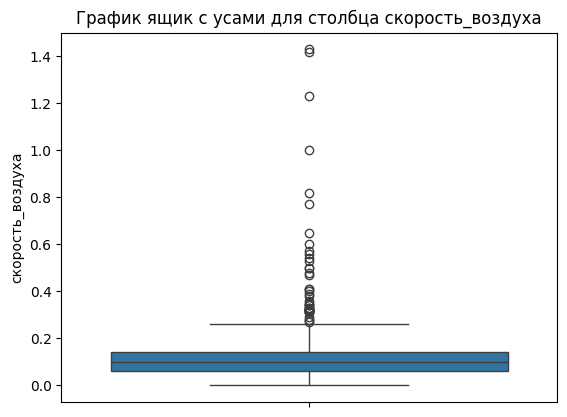

In [93]:
boxplot_chart(df, ['скорость_воздуха'])

In [49]:
df.query(f'рост < {df["рост"].quantile(0.05)}')

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
287,2012,Зима,Влажный субтропический муссонный,Дели,Индия,Смешанный,Вентиляция,NaN,35.0,Мужской,...,0.01,5.23,55.0,True,False,False,True,True,15.5,0
301,2012,Лето,Субтропическое высокогорье,Шимла,Индия,Смешанный,Вентиляция,Механическое отопление,55.0,Женский,...,0.00,147.30,58.0,True,True,True,True,False,18.5,0
306,2012,Лето,Субтропическое высокогорье,Шимла,Индия,Вентиляция,NaN,NaN,45.0,Мужской,...,0.04,5.74,53.0,True,True,True,True,True,18.5,0
325,2012,Зима,Жаркий полузасушливый,Ахмедабад,Индия,Вентиляция,NaN,NaN,25.0,Женский,...,0.05,144.80,44.0,True,False,False,True,True,21.3,0
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,Смешанный,Кондиционирование,Механическое отопление,25.0,Женский,...,0.04,134.60,43.0,True,True,False,True,True,8.5,0


Можем предпложить, что в Индии длина измеряется по-своему. Возможно это футы или Ilahi Gaz. Но если переводить в эти величины, то можно ужаснутся большими значениями. По тому данные значения будем считать NaN,
в заполнении пропусков будем думать, как такие значения заполнять.

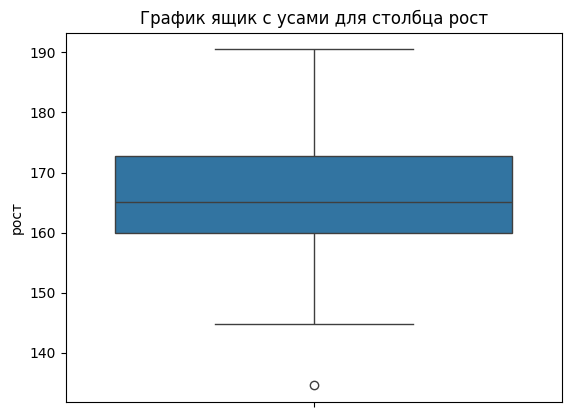

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,Смешанный,Кондиционирование,Механическое отопление,25.0,Женский,...,0.04,134.6,43.0,True,True,False,True,True,8.5,0


In [50]:
df['рост'] = df['рост'].apply(lambda x: np.nan if x < 10 else x)
boxplot_chart(df, ['рост'])
df.query('рост < 140')

У нас остался один предполагаемый выброс. Мы не можем его таким считать, так как это возможно особенность человека.

In [51]:
df.query(f'среднемесячная_температура_на_улице > {df["среднемесячная_температура_на_улице"].quantile(0.95)}')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                                                                               'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                                                               'среднемесячная_температура_на_улице']].sort_values(by='среднемесячная_температура_на_улице')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
1,Cубтропический океанический,Лето,США,Техас,-2.0,23.7,23.777778,84.0
14,Cубтропический океанический,Лето,США,Техас,-1.5,23.0,23.200000,84.0
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,23.833333,84.0
44,Cубтропический океанический,Лето,США,Техас,-2.0,23.9,24.000000,84.0
34,Cубтропический океанический,Лето,США,Техас,2.0,24.1,24.300000,89.0
39,Cубтропический океанический,Лето,США,Техас,2.0,24.4,24.400000,89.0
30,Cубтропический океанический,Лето,США,Техас,-1.3,24.2,24.300000,91.0
20,Cубтропический океанический,Лето,США,Техас,0.0,23.6,23.600000,91.0
68,Cубтропический океанический,Лето,США,Техас,1.5,25.9,26.000000,91.0
28,Cубтропический океанический,Лето,США,Техас,-0.5,24.6,23.900000,91.0


США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

In [ ]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < df["среднемесячная_температура_на_улице"].quantile(0.95) else ((5 / 9) * (x - 32)))
df['среднемесячная_температура_на_улице'].describe()
boxplot_chart(df, ['среднемесячная_температура_на_улице'])

Оставшиеся выбросы заменим на NaN для последующей замены на этапе заполнения пропусков

In [53]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < 100 else np.nan)
df['среднемесячная_температура_на_улице'].describe()

count    482.000000
mean      24.035731
std        6.630709
min        3.388889
25%       22.000000
50%       22.000000
75%       29.900000
max       32.800000
Name: среднемесячная_температура_на_улице, dtype: float64

## EDA